+++
title = "Uncertain Data"
subtitle = ""
date = 2019-04-15T00:00:00
lastmod = 2019-04-15T00:00:00
draft = false

# Authors. Comma separated list, e.g. `["Bob Smith", "David Jones"]`.
authors = ["Kristian A. Haaga"]

tags = []
summary = "A Julia package for dealing with uncertain values and datasets."

# Projects (optional).
#   Associate this post with one or more of your projects.
#   Simply enter your project's folder or file name without extension.
#   E.g. `projects = ["deep-learning"]` references
#   `content/project/deep-learning/index.md`.
#   Otherwise, set `projects = []`.
projects = ["uncertaindata"]
+++

``UncertainData.jl`` is a Julia package for dealing with data values with associated uncertainties and datasets consisting of uncertain values. The main goals are:

* Systematic and intuitive ways of representing uncertain data.

* Easy and robust resampling of uncertain data, given pre-defined or custom user-defined constraints.

* Provide a framework for robust computation of ensemble statistics for uncertain data.

``UncertainData.jl`` was originally designed to form the backbone of the uncertainty handling in the <a href=https://www.earthsystemevolution.com/project/causalitytools/>``CausalityTools.jl``</a> package.

Source code can be found at <a href=https://github.com/kahaaga/UncertainData.jl>https://github.com/kahaaga/UncertainData.jl</a>.

For more information, see the package documentation at <a href=https://kahaaga.github.io/UncertainData.jl/dev/>https://kahaaga.github.io/UncertainData.jl/dev/</a>.

If you use ``UncertainData.jl`` for any of your projects or scientific publications, please cite this small   <a href=https://joss.theoj.org/papers/10.21105/joss.01666>Journal of Open Source Software (JOSS) publication</a>.


# An example

Here's an example illustrating how the functionality of the ``UncertainData.jl`` package is integrated with the ``CausalityTools.jl`` package.  The ``jupyter`` notebook was run with a Julia 1.2 kernel. 

In [36]:
using UncertainData, CausalityTools, Distributions, StatsBase, 
    Test, Interpolations, Measures, LaTeXStrings 
using Plots; pyplot();

## Time series with uncertainty
Let's consider a case of two unidirectionally coupled first-order autoregressive (AR1) processes. We record `N` points from the built-in `ar1_unidir` system, collect the 1st and 2nd
variables as `X` and `Y` and add some uncertainties to both the indices and the values.

In [15]:
N = 100
sys = ar1_unidir(c_xy = 0.8)
X, Y = example_uncertain_indexvalue_datasets(sys, N, (1, 2), tstep = 5,
    d_xval = Uniform(0.1, 0.3), d_yval = Uniform(0.1, 0.3),
    d_xind = Uniform(1, 3), d_yind = Uniform(1, 3)
    );

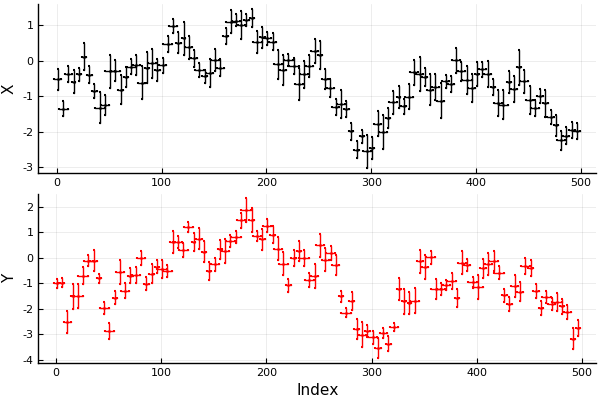

In [16]:
qs = [0.05, 0.95] #quantiles

px = plot(X, ylabel = "X", marker = stroke(0.01, :black), ms = 1, c = :black, qs, qs)
py = plot(Y, xlabel = "Index", ylabel = "Y", marker = stroke(0.01, :red), ms = 1, c = :red, qs, qs)
plot(px, py, layout = grid(2, 1), legend = false)

Create a fine-grained interpolation grid over the range of the data.

In [17]:
tmin = max(minimum(mean.(X.indices)), minimum(mean.(Y.indices)))
tmax = max(maximum(mean.(X.indices)), maximum(mean.(Y.indices)))
intp_grid = tmin:0.01:tmax

1.0:0.01:496.0

Decide on a coarser resolution at which we want to analyse the data. Pick all the linearly interpolated data that falls in each bin and summarise it using the `mean` function.

In [18]:
binstep = 5
left_bin_edges = tmin:binstep:tmax
r = InterpolateAndBin(mean, left_bin_edges, Linear(), intp_grid, Flat(OnGrid()))

InterpolateAndBin{Linear}(Statistics.mean, 1.0:5.0:496.0, Linear(), 1.0:0.01:496.0, Flat(OnGrid()))

Draw some interpolated-and-binned realisations and plot them:

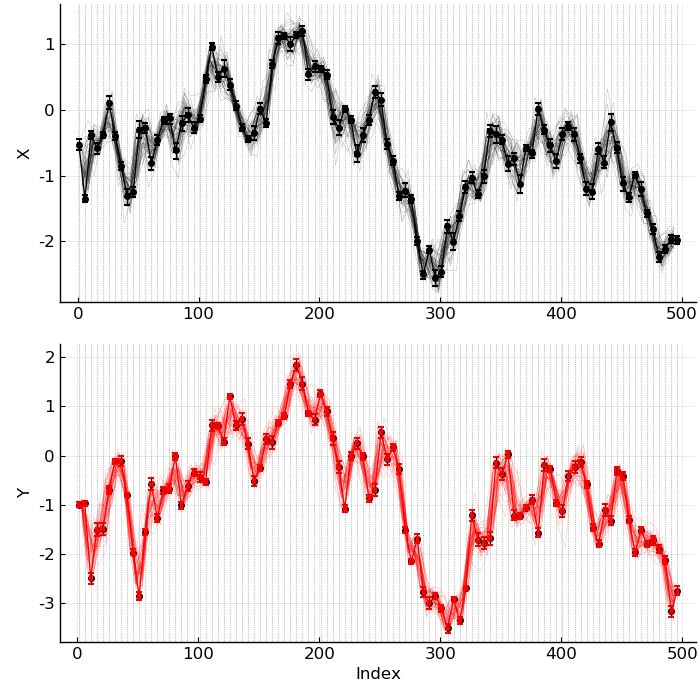

In [26]:
g = left_bin_edges[1:end-1] .+ step(left_bin_edges)/2

#pX = plot(legend = false)
pX = plot(mean.(X.indices), mean.(X.values), label = "X", c = :black)
plot!(X, ylabel = "X", marker = stroke(0.01), c = :black)
vline!(left_bin_edges, c = :black, alpha = 0.5, lw = 0.5, ls = :dot)

for i = 1:50
    plot!(g, resample(X, r), label = "", alpha = 0.3, lw = 0.3, c = :black)
end

#pY = plot(legend = false)
pY = plot(mean.(Y.indices), mean.(Y.values), label = "Y", c = :red)
plot!(Y, xlabel = "Index", ylabel = "Y", marker = stroke(0.01), c = :red)
vline!(left_bin_edges, c = :black, alpha = 0.5, lw = 0.5, ls = :dot)

for i = 1:50
    plot!(g, resample(Y, r), label = "", alpha = 0.3, lw = 0.3, c = :red)
end

plot(pX, pY, layout = grid(2, 1), legend = false, size = (700, 700),
    bottom_margin = 5mm, left_margin = 5mm, tickfont = font(12), 
    guidefont = font(12))

Okay, that looks reasonable! Let's apply a causality test.

## Defining an `InterpolateBinTest`

We'll use a predictive asymmetry test as the causality test. Then we just couple that test with the interpolation-and-binning scheme, and compute the causality between `X` and `Y` over 100 independent realisations.

In [33]:
# Causality test 
k, l, m = 1, 1, 1 # embedding parameters
n_subdivisions = floor(Int, N^(1/(k + l + m + 1)))
state_space_binning = RectangularBinning(n_subdivisions)
ηs = -8:8
te_test = VisitationFrequencyTest(k = k, l = l, m = m,
            binning = state_space_binning, 
            ηs = ηs, b = 2) # use base-2 logarithms
pa_test = PredictiveAsymmetryTest(predictive_test = te_test)

# Define interpolate-and-bin test. Draw 100 independent realisations.
ib_test = InterpolateBinTest(pa_test, r, 100)

InterpolateBinTest{PredictiveAsymmetryTest{VisitationFrequencyTest},InterpolateAndBin{Linear}}(PredictiveAsymmetryTest{VisitationFrequencyTest}(predictive_test = VisitationFrequencyTest(k = 1, l = 1, m = 1, n = 1, τ = 1, b = 2, binning_summary_statistic = mean, estimator = VisitationFrequency(), binning = RectangularBinning(3), ηs = -8:8)), InterpolateAndBin{Linear}(Statistics.mean, 1.0:5.0:496.0, Linear(), 1.0:0.01:496.0, Flat(OnGrid())), 100)

## Compute causality statistic

In [34]:
res_xy = causality(X, Y, ib_test);
res_yx = causality(Y, X, ib_test);

Summarise and get the mean and standard deviation for each prediction lag $\eta$. Plot it.

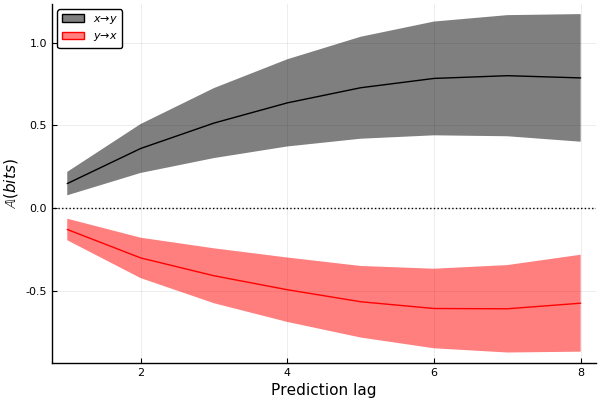

In [48]:
RES_xy = hcat(res_xy...)
RES_yx = hcat(res_yx...)

plot(xlabel = "Prediction lag", ylabel = L"\mathbb{A} (bits)", legend = :topleft)
plot!(1:maximum(ηs), mean(RES_xy, dims = 2), ribbon = std(RES_xy, dims = 2), 
    label = L"x \to y", c = :black)
plot!(1:maximum(ηs), mean(RES_yx, dims = 2), ribbon = std(RES_yx, dims = 2), 
    label = L"y \to x", c = :red)
hline!([0], lw = 1, ls = :dot, c = :black, label = "")

We find that the predictive asymmetry in the causal direction ($\mathbb{A}_{x \to y}$) is positive, whereas the asymmetry in the non-causal direction ($\mathbb{A}_{y \to x}$) is negative. We thus recover the expected unidirectional causal relationship $X \to Y$. Note that because we defined our time series as ``UncertainIndexValueDataset``, the ``causality()`` test function returns a *distribution* of predictive asymmetry values for each prediction lag.